In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf
from kerastuner import RandomSearch


2025-08-10 10:38:31.316384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754822311.548692      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754822311.615792      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_19/1571418814.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


# Load DataSet

In [2]:
path = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ','_')
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.isna().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

# Visualization

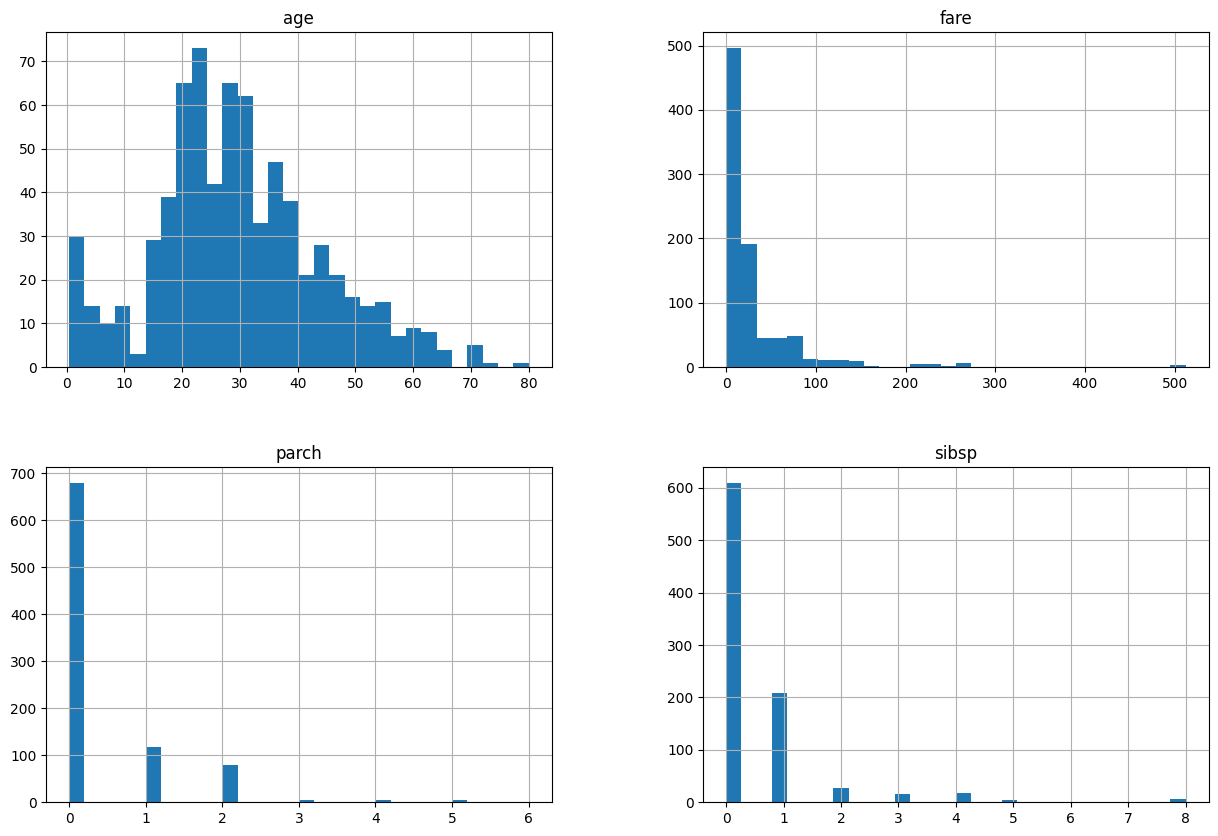

In [8]:
num_col = ['age','fare','parch','sibsp']
df[num_col].hist(figsize=(15,10), bins=30)
plt.show()

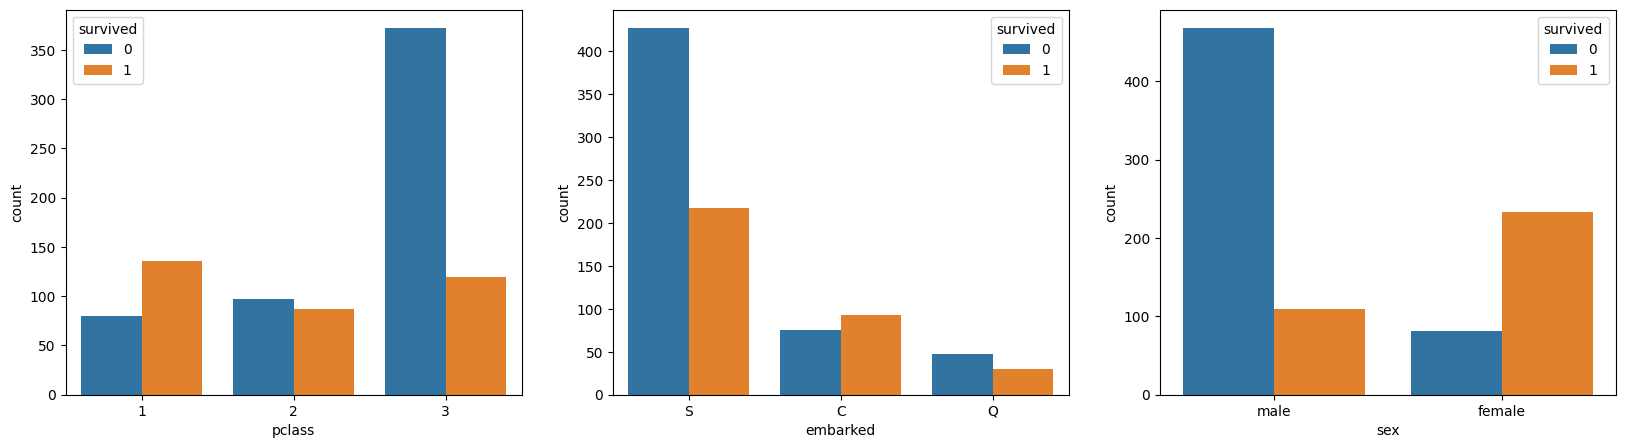

In [9]:
categorical_cols = ['pclass','embarked','sex']
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i], hue='survived')

plt.show()


In [10]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [11]:
# Feature Engineering
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)
df['is_child'] = (df['age'] < 16).astype(int)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [12]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_size,is_alone,is_child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,1,0


# Split DataSet

In [13]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'family_size',
       'is_alone', 'is_child'],
      dtype='object')

In [14]:
selected_features = ["pclass", "sex", "age", "sibsp", "parch", "family_size", "is_alone", "fare", "embarked","is_child"]
X = df[selected_features]
y = df['survived']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y) 

In [16]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print()
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (712, 10)
y_train shape (712,)

X_test shape (179, 10)
y_test shape (179,)


# Data Preprocessing

In [17]:
# "pclass", "sex", "age", "sibsp", "parch", "family_size", "is_alone", "fare", "embarked","is_child"

numerical_cols = ["age","fare"]
categ_cols = ["sex", "embarked"]
rest_cols = list(set(X_train.columns.tolist()) - set(numerical_cols) - set(categ_cols))

In [18]:
print("Numerical columns: ", numerical_cols)
print("Categorical columns: ", categ_cols)
print("Rest columns: ", rest_cols)

Numerical columns:  ['age', 'fare']
Categorical columns:  ['sex', 'embarked']
Rest columns:  ['pclass', 'family_size', 'is_alone', 'parch', 'sibsp', 'is_child']


In [19]:
# Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))
])

rest_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent"))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('categ', categ_pipeline,categ_cols),
    ('rest', rest_pipeline, rest_cols)
])

In [20]:
# Apply on df
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [21]:
print("X_train_final shape", X_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("X_test_final shape", X_test_final.shape)
print("y_test shape", y_test.shape)


X_train_final shape (712, 11)
y_train shape (712,)

X_test_final shape (179, 11)
y_test shape (179,)


In [22]:
# save Preprocessor

MODELS_FOLDER = os.path.join(os.getcwd(),"models")
os.makedirs(MODELS_FOLDER, exist_ok =True)
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER,"preprocessor.joblib"))

['/kaggle/working/models/preprocessor.joblib']

# Model

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu',input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754822327.277423      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/100


I0000 00:00:1754822330.761494      58 service.cc:148] XLA service 0x7a044c004620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754822330.762339      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754822331.091967      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4062 - loss: 0.7025

I0000 00:00:1754822331.927452      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5918 - loss: 0.6739 - val_accuracy: 0.6434 - val_loss: 0.6189
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6909 - loss: 0.5920 - val_accuracy: 0.7133 - val_loss: 0.5715
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7183 - loss: 0.5570 - val_accuracy: 0.7413 - val_loss: 0.5226
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7823 - loss: 0.4878 - val_accuracy: 0.7972 - val_loss: 0.4765
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8025 - loss: 0.4370 - val_accuracy: 0.7902 - val_loss: 0.4640
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8332 - loss: 0.4241 - val_accuracy: 0.8182 - val_loss: 0.4493
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8371 - loss: 0.4088 - val_accuracy: 0.8042 - val_loss: 0.4577
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8245 - loss: 0.3949 - val_accuracy: 0.8182 - val_loss: 0.

In [26]:
# Evaluating the Model on test

test_loss, test_accuarcy = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuarcy:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8027 - loss: 0.6530
Test Loss: 0.7256
Test Accuracy: 0.7933 %


# Visualize Model Loss/ Model Accuracy

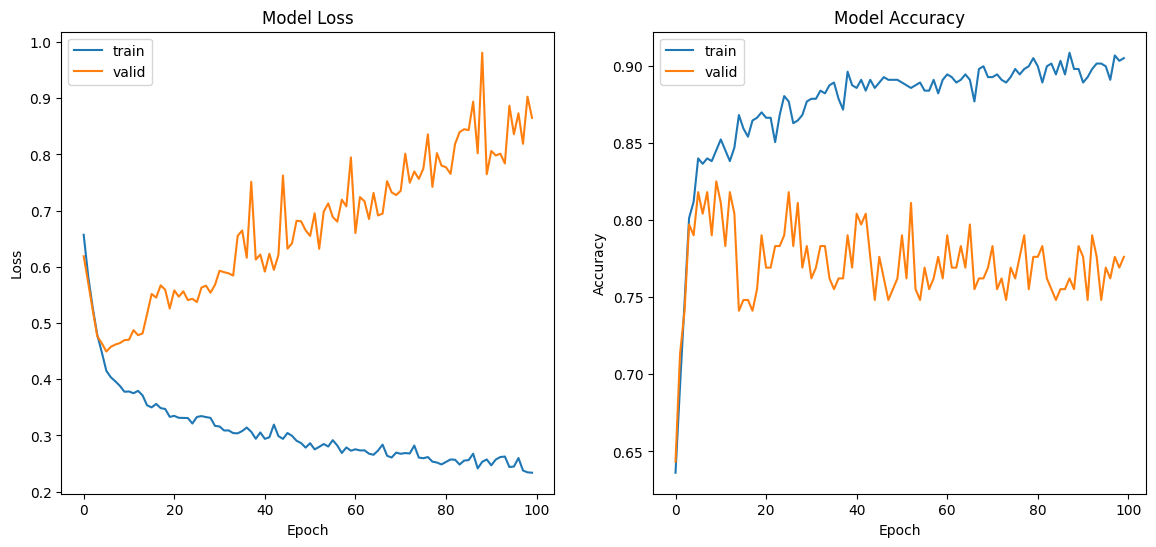

In [27]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'],label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

-- Overfitting

# Enhancing Model Performance(Drop Out)

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dropout(0.5, seed=90),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=90),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=90),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Early Stopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=7,
                                                 restore_best_weights=True)

history = model.fit(X_train_final, y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.2,
                   callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.4757 - loss: 0.7936 - val_accuracy: 0.6364 - val_loss: 0.6606
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6087 - loss: 0.6632 - val_accuracy: 0.6294 - val_loss: 0.6404
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5776 - loss: 0.6712 - val_accuracy: 0.6084 - val_loss: 0.6301
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6385 - loss: 0.6627 - val_accuracy: 0.6224 - val_loss: 0.6208
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6175 - loss: 0.6486 - val_accuracy: 0.6434 - val_loss: 0.6117
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6263 - loss: 0.6516 - val_accuracy: 0.6923 - val_loss: 0.5988
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6235 - loss: 0.6267 - val_accuracy: 0.7133 - val_loss: 0.5882
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6430 - loss: 0.6291 - val_accuracy: 0.7133 -

In [30]:
# Evaluate on test Data
test_loss, test_accuracy = model.evaluate(X_test_final,y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8077 - loss: 0.4630
Test Loss: 0.4491
Test Accuracy: 0.8101%


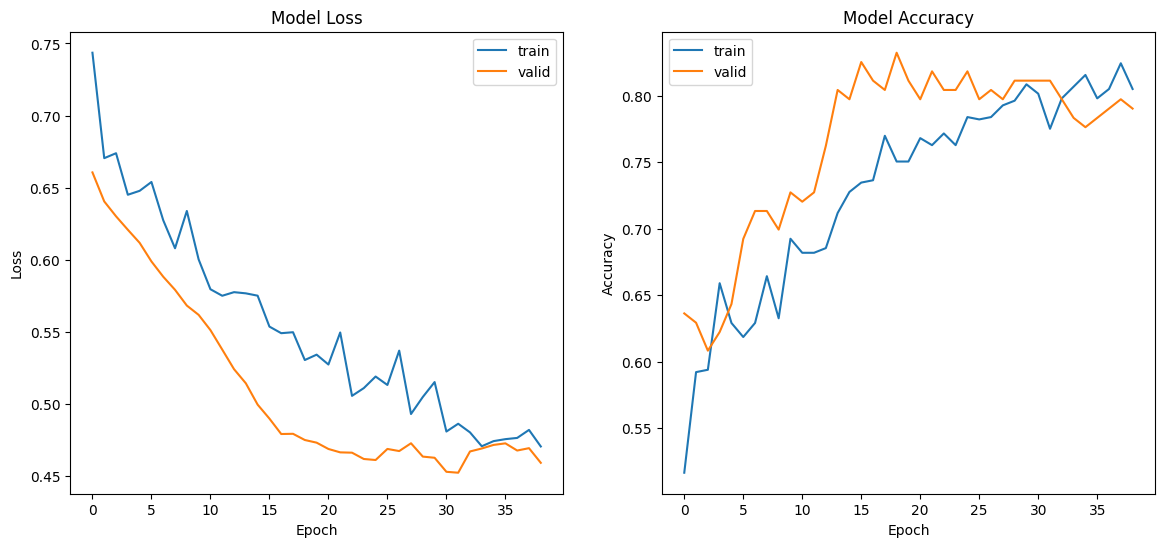

In [31]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.sca(ax[1])
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# FineTuning

## KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. 
   * KerasTuner is a general-purpose hyperparameter tuning library.
   * The first thing we need to do is writing a function, which returns a compiled Keras model. It takes an argument hp for defining the hyperparameters while building the model.

In [32]:
!pip install -q keras-tuner

In [33]:
def model_build(hp):
    model = tf.keras.models.Sequential([

      
        tf.keras.layers.Input(shape=(X_train_final.shape[1],)),


        tf.keras.layers.Dense(units=hp.Int("units_1", min_value=32, max_value=256, step=32),
        activation="relu"),


        tf.keras.layers.Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)),


        tf.keras.layers.Dense(units=hp.Int("units_2", min_value=32, max_value=256, step=32),
        activation="relu"),


        tf.keras.layers.Dropout(hp.Float("dropout_2", min_value=0.0, max_value=0.5, step=0.1)),

     
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [35]:
tuner = RandomSearch(hypermodel=model_build,
                     objective="val_accuracy",
                     max_trials=10,
                     executions_per_trial=2,
                     directory="hyperparam_tuning",
                     project_name="titanic",
                     seed=200)

In [36]:
# Running tuner
tuner.search(X_train_final, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 14s]
val_accuracy: 0.8216783106327057

Best val_accuracy So Far: 0.8391608595848083
Total elapsed time: 00h 02m 30s


In [37]:
# Getting the best model 
best_model = tuner.get_best_models(num_models=1)[0]
best_model

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [38]:
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7923 - loss: 0.4652
Test Loss: 0.4505
Test Accuracy: 0.7989 %


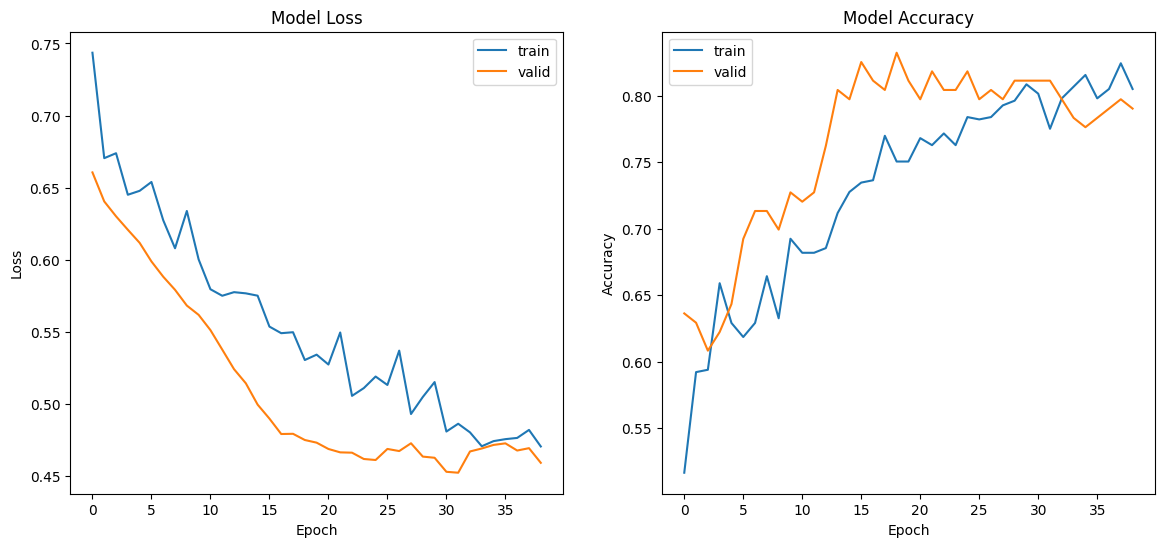

In [39]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model Save

In [40]:
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), "models")
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)

In [41]:
best_model.save(os.path.join(MODELS_FOLDER_PATH, "best_model_titanic_df.keras"))

In [42]:
# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7923 - loss: 0.4652 
Test Loss: 0.4505
Test Accuracy: 0.7989 %
